-------

# BloomTech Data Science - Apply Auto-Encoders to Restore Images

## Unit 4.3.3

Michael Luo

2023/03/08

Watch the following 4 minute video on using an Auto-Encoder called DeepRemaster to restore old and grainy black and white video into higher quality, color video. 

It's a great video that sets up what we will be doing with our auto-encoder in this section. 

Here's the paper [**DeepRemaster: Temporal Source-Reference Attention Networks for
Comprehensive Video Enhancement**](https://arxiv.org/pdf/2009.08692.pdf) mentioned in this video, just in case you'd like to read through it. 

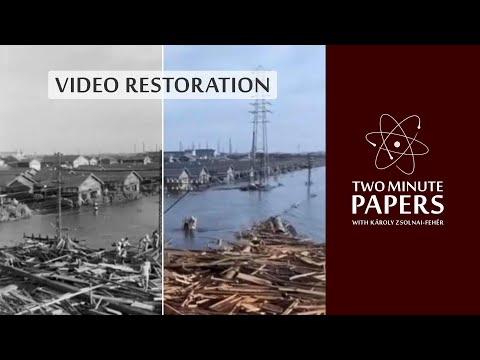

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('EjVzjxihGvU', width=1000, height=500)

As you saw in the video, the model architecture for DeepRemaster is a big complex beast of a model. And, since it is processing video data, you can image how much computational resources and time are required to properly train such a large model. 

In this section, we will perform the same time of process but on a smaller and simpler scale - though the basic idea is the same. We will train an auto-encoder to restore damaged images. The beautiful and beneficial thing about performing the same basic restoration process but on a simpler problem is that we are able to understand the basic process without too many complications. Then, if this is something that you'd like to explore further, you can do so with the advantage of already having solved a similar and simpler version of the same problem. 

In [ ]:
import os
import random
import numpy as np
from numpy.random import normal

import tensorflow as tf
from tensorflow import keras

# need these layers for 1st section
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

from sklearn.utils import shuffle
from keras.datasets.mnist import load_data


# need these layers for 2nd section
from keras import layers
from keras.layers import Reshape, Conv2DTranspose, Flatten

import matplotlib.pyplot as plt
%matplotlib inline

# Exercise 1: Application of Auto-Encoders


# Restore Damaged MNIST Dataset

In this exercise, our task is to build a model that restores damaged images, namely damaged MNIST digits. Because this is an exercise, we'll have to damage the images ourselves by adding random noise from a normal distribution. 

### Load the MNIST Image data, using the function provided by keras
Then normalize the data

In [ ]:
# load in mnist dataset 
(x_train, y_train), (x_test, y_test) = load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
# normalize pixel values between 0 and 1 for both the train and test set 
# save results to `x_train_norm` and `x_test_norm`

max_pixel_value = np.max(x_train)

x_train_norm, x_test_norm = x_train.astype(float) / max_pixel_value, x_test.astype(float) / max_pixel_value

In [ ]:
x_train_norm.shape

(60000, 28, 28)

### Visualize Original and Damaged Images

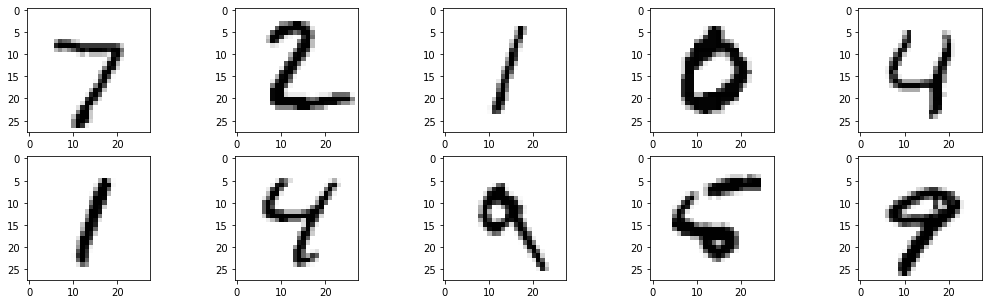

In [ ]:
# here we can see the first 10 original images from the test set 
plt.figure(figsize=(18,5))
# helper function used to plot images 
for index in range(10):
    plt.subplot(2,5, index+1)
    plt.imshow(x_test_norm[index], cmap=plt.cm.binary)
plt.show()

### Damage Our Images

We'll damage the images by adding noise to each pixel. <br>
The noise will be samples from a normal (Gaussian) distribution, <br>
We use the imported `numpy.random.normal` to generate the samples.<br><br>
We'll generate noise arrays `x_train_noise` and `x_test_noise` and add them to<br> `x_train_norm` and `x_test_norm` respectively to get the noisy images.<br>
The noise arrays must be the same size as the image arrays to which they will be added. <br>

Look up the documentation of `numpy.random.normal` to find out how to generate noise arrays of the required shapes.



In [ ]:
# parameters of the normal distribution to sample from 
mean = 0.5
stddev = 0.3

# create noise arrays x_train_noise and x_test_noise by sampling 
#    from a normal distribution with the given mean and stddev
x_train_noise = normal(loc=mean, scale=0.3, size=(x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test_noise = normal(loc=mean, scale=0.3, size=(x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# create the noisy train data by adding the appropriate noise array to x_train_norm
x_train_noisy = x_train_norm + x_train_noise

# create the noisy test data by adding the appropriate noise array to x_test_norm
x_test_noisy = x_test_norm + x_test_noise

### Visualize the damaged images

You should see highly grainy images of hand written digits below. By normalizing our images and adding noise sampled from a normal distribution centered around 0.5, we have created damaged images. Now our next task is to build an auto-encoder that learns how to restore the original images. 

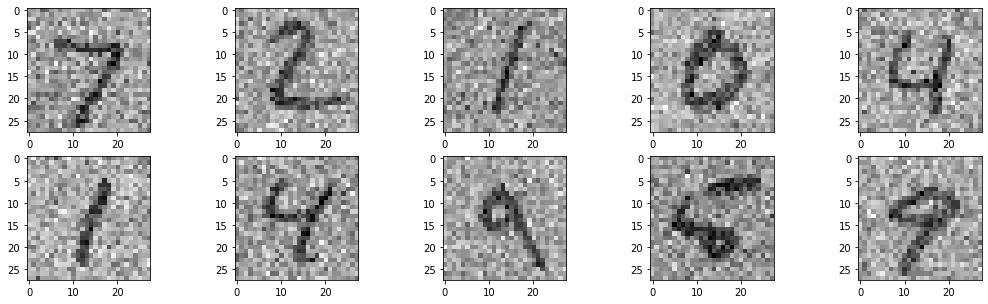

In [ ]:
plt.figure(figsize=(18,5))

# helper function used to plot images 
for index in range(10):
    plt.subplot(2,5, index+1)
    plt.imshow(x_test_noisy[index], cmap=plt.cm.binary)
plt.show()

### Build an Image Restoration Auto-Encoder

You saw in the guided project that we can build an Auto-Encoder using Fully Connected Feed Forward (FCFF) layers; in Keras they're called Dense layers. Or we can build a Convolutional Auto-Encoder by using Conv2D and MaxPool2D layers. 

You are encouraged to experiment and build out an architecture of your choosing. However using a Convolutional Auto-Encoder is encouraged since that architecture is specifically designed for image data. 

Reference today's guided project for examples of how to build an Auto-Encoder. 

In [ ]:
# Create a decoder model using the Model() class/API

# Input layer using Input() class
input_img = Input(shape=(28, 28, 1))

conv_filter_size = (5,5)

# Create an encoder model 

#1st convolutional layer: 24 feature maps of 14x14
encoded = Conv2D(24, conv_filter_size, activation=None, padding="same")(input_img)
encoded = MaxPooling2D(padding="same")(encoded)

#2nd convolutional layer: 12 feature maps of 7x7
encoded = Conv2D(12, kernel_size=(3,3), activation="relu", padding="same")(encoded)
encoded = MaxPooling2D(padding="same")(encoded)

# last layer: 25 feature maps of 4x4
encoded = Conv2D(25, kernel_size=(2,2), activation="relu", padding="same")(encoded)
encoded = MaxPooling2D(padding="same")(encoded)

# flatten 3D tensor into 1D vector in preparation for the Dense layer 
encoded = Flatten()(encoded)

# this is the coding, the output of the encoder layer
coding = Dense(64, activation="relu")(encoded)

# reshape 1D vectors into 2D arrays, for input to Convolution layers 
#     64 = 4 * 4 * 4
encoded = Reshape((4,4,4))(coding)

### decoding layers ###
decoded = Conv2D(12, kernel_size=(2,2), activation="relu", padding="same")(encoded)
decoded = UpSampling2D()(decoded)
                  
decoded = Conv2D(16, kernel_size=(3,3), activation="relu", padding="same")(decoded)
decoded = UpSampling2D()(decoded)
                  
decoded = Conv2D(24, kernel_size=(3,3), activation="relu")(decoded) # in order to get to 14x14 instead of 16x16
decoded = UpSampling2D()(decoded)

# because this is the final reconstruction of the original image,
#   we must necessarily use a single weight matrix for the convolution 
#   so that the final output is a 2D matrix and not a rank 3 Tensor (i.e. a volume)
decoded = Conv2D(1, conv_filter_size, activation="sigmoid", padding="same")(decoded)

restore_model = Model(inputs=input_img, outputs=decoded, name="restore_model")
restore_model.summary()

Model: "restore_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 24)        624       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 24)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 12)        2604      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 12)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 25)        

### Compile model 

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

# compile model 
restore_model.compile(optimizer='nadam',
                      loss='mean_squared_error')

# make tensorboard callback
logdir = os.path.join("logs", "restore_model")
tensorboard = TensorBoard(log_dir=logdir)

# early stopping
early_stop = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)

### Fit model
We will train the autoencoder to learn how to denoise a noisy image by using the uncorrupted image as the target!

In [ ]:
# Input: `x_train_noisy` as training data
# Target:  `x_train_norm` 
# Testing holdout is the validation data

restore_model.fit(x=x_train_noisy, 
                  y=x_train_norm, 
                  epochs=50, 
                  validation_data=(x_test_noisy, x_test_norm), 
                  workers=-1,
                  batch_size=128,
                  callbacks=[tensorboard, early_stop])


Epoch 1/50
469/469 [==============================] - 7s 8ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0191 - val_loss: 0.0182
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0184 - val_loss: 0.0178
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0178 - val_loss: 0.0178
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0174 - val_loss: 0.0168
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0169 - val_loss: 0.0165
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0166 - val_loss: 0.0162
Epoch 8/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0162 - val_loss: 0.0168
Epoch 9/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 10/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0155 - val_loss: 0.0150

### Use our Autoencoder to Restore Damaged Images!

Now that our autoencoder `restore_model` has been trained, we can use it to restore damaged images. 

Pass in `x_test_noisy` to the `.predict()` method, and save the results to `restored_imgs`

In [ ]:
x_test_noisy.shape

(10000, 28, 28)

In [ ]:
# restore damaged test set images 

restored_imgs = restore_model.predict(x_test_noisy)

313/313 [==============================] - 1s 2ms/step


### Visualize Damaged Images

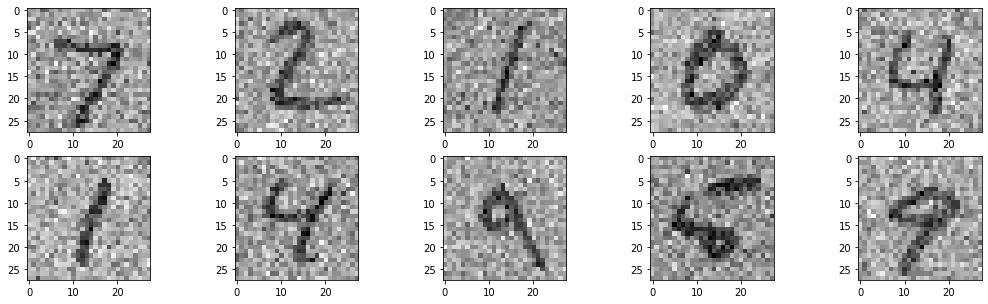

In [ ]:
plt.figure(figsize=(18,5))

# display the first 10 images from `x_test_noisy`
for index in range(10):
    plt.subplot(2,5, index+1)
    plt.imshow(x_test_noisy[index], cmap=plt.cm.binary)
plt.show()

### Visualize Restored Images

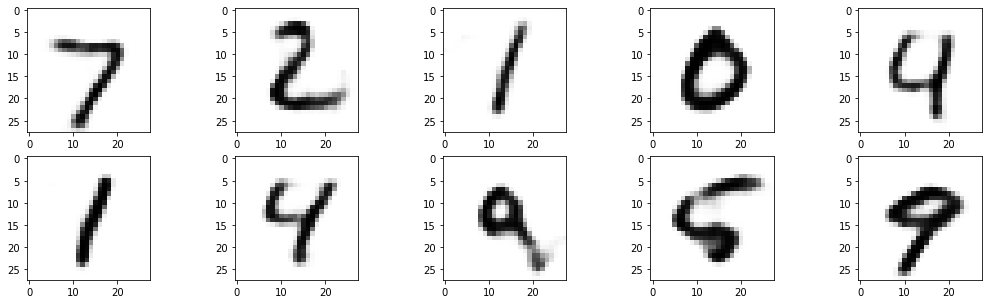

In [ ]:
plt.figure(figsize=(18,5))

# display the first 10 images from `restored_imgs`
for index in range(10):
    plt.subplot(2,5, index+1)
    plt.imshow(restored_imgs[index,:,:,0], cmap=plt.cm.binary)
plt.show()

### Conclusion 

Ok - so it worked! We were able to restored damaged images using an auto-encoder, applying the same essential idea as in the video from the top of the notebook. 

You might be thinking to yourself "Wait a minute?! Doesn't this feel a little circular?In real life, we'd have only the damaged images, not the uncorrupted versions! What do we do then?"

Suppose you wanted to restore a set of damaged images, or perhaps an entire video (which is after all just an ordered set of images). One approach would be to find a way to restore a small number of images via some non-deep learning method, such as hiring an artist to do it manually.  Once you have a sufficient number pairs of damaged and restored images, you can create a training set and train a resstoration model. From that point on, the model can do the restoration in an automated fashion.

-----

# Exercise 2: Introduction to Variational Auto-Encoders


We will take the Standard Auto-Encoder framework that we have been playing with and change two things to make it even more powerful. To understand these changes, you will first watch the provided video; then, we'll break down the important bits in the notebook. 

Variational Autoencoders are **generative models**. A generative model learns a **probabilistic representation** of the data, <br>
and is then capable of synthesizing an infinite variety of new examples from that distribution. Truly magic! <br><br>
To experience the magic at first-hand, take a look at the page [This Person Does Not Exist](https://thispersondoesnotexist.com/). Every time you refresh the page, you are shown an image of an imaginary person! These images are  produced by another kind of generative model called a Generative Adversarial Network (GAN).<br><br>

Although you are highly encouraged to experiment with the code provided, you will not be asked to fill in any missing code in this section. 

The questions at the end of this section that test your reading comprehension of the material on variational autoencoders.


## First some Theory

Watch the following video to get a crash course on the theory of Variational Auto-Encoders. 

The first part of the video is a great recap of the standard autoencoder.  The section introducing the Variational Auto Encoder (VAE) **starts at about 5:40 and ends at about 9:06**. Afterward, he discusses a more sophisticated version of VAE that is outside the scope of today's assignment -- still interesting, but optional.

Don't stress out if you don't understand everything he is saying. Take note of the following: 

- Watch the VAE section of the video 2 - 3 times and absorb as much information as you can
- We will unpack the important bits later in the notebook 


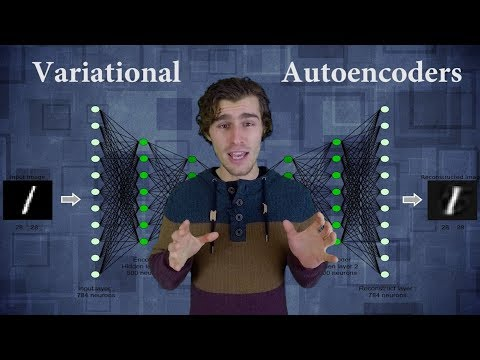

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('9zKuYvjFFS8', width=1000, height=500)

![](https://lh3.googleusercontent.com/proxy/9StAnnRiBvF4rNIMEXj2Qc5kGvWHQu7H6wOqxYI9wAPCN3Jy8JUE4awTyslXvFO2Etb2-yY8xgFvAH0zNMx8BUQmQ0Ca2FwgOw)

Having watched the video, you'll see that there are a lot of technical details, but the most important ideas are:

- The introduction of the **`z_mean`** and  **`z_log_var`** vectors 
- The two-part loss function with the **Reconstruction loss** and **KL loss** components 

Let's focus on the **`z_mean`** and  **`z_log_var`** vectors for now and we'll come back to the loss function later. 

Notice that the Variational Auto-Encoder is our standard Auto-Encoder plus the **`z_mean`** and  **`z_log_var`** vectors in the middle. 

Standard Auto-Encoders also represent data in a **latent vector** - it's simply the output of the last encoding layer!


## Sampling the Normal Distribution in Latent Space

### Latent Space 

A Latent Space is a representation of data in compressed form, i.e. representing high dimensional data in a low dimensional space. If your interest in piqued, read [Understanding Latent Space in Machine Learning](https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d#:~:text=The%20latent%20space%20is%20simply,representations%20of%20data%20for%20analysis.)<br><br>

### Latent N-dimensional Distribution 

![](https://theaisummer.com/assets/img/posts/Autoencoder/vae.png)


The image below shows the architecture of a **Variational Auto-Encoder**. Notice that it looks similar to standard auto-encoder? <br>
Except for those latent vectors in the middle. 

In the standard autoencoder, the latent vector is deterministically computed at the the output of the encoder mode.

The basic idea of the VAE is to compute the latent vector by sampling from a Gaussian distribution with a mean and variance that are **parameters to be learned by the network**.

![](https://bookdown.org/phamtrongthang123/notebookCEVAE/imgs/2020-04-12-10-49-37.png)

$$\mathbf{Z} = \mathbf{\mu} + \mathbf{\sigma} \bigodot \mathbf{\epsilon}$$

Where $\epsilon$ is sampled from a multivariate standard normal distribution 

$$\epsilon \sim \mathcal{N}(\mu,\,\sigma^{2}) ~=~ \mathcal{N}(0, 1) $$

And $\bigodot$ means matrix product. 

We know that **mean** and **variance** are just numbers, single floating-point values, right? <br>
So how do we get vectors from these distribution parameters?
The vectors come from an [**N-dimensional Normal distribution**](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). <br>

So far, we've  dealt mostly with univariate probability distributions, which are functions of a single variable. However, it is possible to have probability distributions that are functions of many variables! One example is the [**multinomial distribution**](https://en.wikipedia.org/wiki/Multinomial_distribution) which came up in Module 1 this week when we needed to sample from a set of N positive numbers that sum to 1. <br>

In [27]:
class Sampling(layers.Layer):
    """
    Uses (z_mean, z_log_var) to sample a z vector from the latent N-dimensional Normal distribution
    i.e. Z is the vector encoding a digit.
    """
    def call(self, inputs):
        
        # recall from the video that z_mean and z_log_var are vectors 
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        # sample from an N-dimensional normal distribution
        # epsilon is given shape (batch, dim) because we are adding it to z_mean which has shape (batch, dim)
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        # output of tf.exp() is a vector 
        sigma = tf.exp(0.5 * z_log_var) # this just restores the standard deviation
        
        # this is our hidden latent vector made up of a mean and variance vector 
        # variance vector is scaled by epsilon, which is sampled from a normal distribtuion 
        # When the guy in the video said "stochastic" in reference to epsilon, he meant random 
        Z = z_mean + sigma * epsilon
        
        # return hidden latent vector 
        return Z

# Build a Variational Auto-Encoder model

We'll build the Encoder model, followed by the Decoder model. <br>

Then we'll put them together using Keras's Model API for building models, just like we did in the guided project. 

Note that the there is nothing special about the the Encoder or Decoder architectures we are using. You can experiment with different architectures after you've gone through the notebook once. 

## Build the Encoder Model



In [32]:
# recall from the video that the more dimensions that our latent vector has,
# the better the results of our model 
latent_dim = 2

# shape of our input data
# we are creating our input layer using Keras's Input() class
# the only thing that input layers really do is define the dimensionality of the input data for the model
encoder_inputs = Input(shape=(28, 28, 1))

# these are the hidden layers of our encoder model 
# `x` is the output from each layer 
# recall that the data is in the shape of a matrix, hence Conv2D - 2D as in 2-dimensional 
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# now flatten data matrix into data vector 
x = Flatten()(x)
# pass data vector into FCFF layer 
x = Dense(16, activation="relu")(x)

# recall that ordinarily the output of the last encoding layer is the latent vector 
# but here we are creating two output layers for our encoder - one for the mean and one for the log variance 
# returns a 2-dim mean vector
z_mean = Dense(latent_dim, name="z_mean")(x)
# returns a 2-dim log variance vector 

z_log_var = Dense(latent_dim, name="z_log_var")(x)
# pass mean and variance vector into Sampling class in order to create the Z vector,  Z = mean + var * epsilon
z = Sampling()([z_mean, z_log_var])

# this is our encoder model 
# inputs are the original images
# outputs are the Z vectors: mean, log variance, and the complete Z, i.e. vector Z = mean + var * epsilon
encoder = Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 14, 14, 32)   320         ['input_6[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_18[0][0]']              
                                                                                                  
 flatten_4 (Flatten)            (None, 3136)         0           ['conv2d_19[0][0]']              
                                                                                            

## Build the Decoder Model

Nexty we'll create the decoder model.

There is a new layer here that we should talk about, it's the **Conv2DTranspose** layer. 

This is also known as a **Deconvolutional layer**. It's like the Convolutional layer that we learned about in Sprint 3 Module 2 but it "moves" in the opposite direction. 


### Deconvolution

![](https://miro.medium.com/max/1086/1*AbCrAqPBfkqGRdhKtiZQqA.png)

On the **left hand side** we see what a **Convolution** looks like (this should look familiar). The layer is taking the original image (or feature map) on the left and applying a convolution, the result is a feature map on the right with a smaller dimensionality. 

On the **right hand side** we see what a **Deconvolution** looks like. The layer is taking the feature map (the output of a convolution layer) and attempting to rebuild the original image. 

Recall that a  **Convolution**  slides a weight matrix over an image in order to create features, which are stored as an array called a **Feature Map.** 

The **Deconvolution**  layer starts with a **Feature Map** and tries to create the original image. 

Hence **Deconvolution** is like **Convolution**  just moving in the opposite direction. 

For a deeper explanation, see the article [**Convolutions: Transposed and Deconvolution**](https://medium.com/@marsxiang/convolutions-transposed-and-deconvolution-6430c358a5b6)


Another reference is the [**Keras docs on on the Conv2dTranspose layer**](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/)

In [33]:
# the input layer to our decoder has the same dimensionality as the latent vector
# which is the input to the decoder
latent_inputs = Input(shape=(latent_dim,))

# these are the hidden layers of our decoder 
# the data at this point is in a vector, the Z latent vector 
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# reshape vector into a matrix
x = Reshape((7, 7, 64))(x)

# increase the size of the matrix by using Deconvolutional layers
# notice that the number of feature maps (i.e. the first parameter values) are mirror images
# of the number of feature maps from the Conv2D layers in the Encoder
# we saw this mirroring in the auto-encoders we built in the guided project 
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

# this is the final layer in out decoder
# therefore this layer outputs the reconstruction of the original image 
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

# this is our decoder model 
decoder = Model(inputs=latent_inputs, outputs=decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

## Combine Encoder & Decoder into a Variational Auto-Encoder 

Now that we've created the Encoder and Decoder models, we can combine them to build our Variational Auto-Encoder using a [keras custom model](https://keras.io/guides/customizing_what_happens_in_fit/).<br>

In order to keep our code tidy, let's define the VAE model as a class. 

**Side Note:** 

You've probably noticed how much code needs to be written just to run a gridsearch experiment in Sprint 2, and now all the code that one needs to write to create a deep learning VAE model. Yeah, welcome to Deep Learning, folks. Deep Learning involves a lot of software engineering! Something to consider if you're considering spending a lot of time building Deep Learning models.  To that point, it is a Good Thing that you're exposed to all of this now, so that you can get an honest and proper taste of what this kind of work is really like!


**Property Decorator Function**

You might have noticed the python decorator above the `metrics()` method in the class below. 

```python
    @property
    def metrics(self):
        """
        Returns all losses in a list
        """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
```

If you're not familiar with this decorator, check this out: [**Python @property decorator**](https://www.programiz.com/python-programming/property)

In [34]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        """
        This class build a Variational Auto-Encoder. It accepts an Encoder and Decoder model as input. 
        
        Note
        ----
        This VAE class is inheriting Keras's Model API so that it can use the Model class methods 

        """
        # how python 3 handles inheritance 
        super(VAE, self).__init__(**kwargs)
        # set encoder model as class attribute
        self.encoder = encoder
        # set decoder model as class attribute 
        self.decoder = decoder
        # set mean function as class attribute - this calculates the total loss
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        # set mean function as class attribute - this calculates the reconstruction loss
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        # set mean function as class attribute - this calculates the kl loss
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        """
        Returns all losses in a list
        """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """
        Training our model via gradient descent and back-propagation 
        """
        
        # we used tf.GradientTape() in Sprint 2 Module 2 to run Gradient Descent from scratch 
        with tf.GradientTape() as tape:
            # pass input data into encoder model 
            # output of encoder model is the hidden state distribution parameters and hidden state vector 
            z_mean, z_log_var, z = self.encoder(data)
            
            # pass hidden state vector into decoder model 
            reconstruction = self.decoder(z)
            
            # calculate the reconstruction loss 
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            
            # calculate the kl loss
            #                (1 + z_sigma   - (z_mean)^2        - e^(z_sigma) ) 
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # recall that we used tf.reduce_sum() in Sprint 2 Module 4 assignment 
            # it takes the sum of the vector components 
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # calculate the total loss by adding the two loss components 
            total_loss = reconstruction_loss + kl_loss
            
        # now that we have calculated the loss function, we can perform Gradient Descent
        # we pass in the loss function and the weights that we want to update via Gradient Descent 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # log the total loss
        self.total_loss_tracker.update_state(total_loss)
        
        # log the reconsgrution loss 
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        # log the kl loss 
        self.kl_loss_tracker.update_state(kl_loss)
        
        # return all the losses in a dictionary 
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Loss Function 

Let's revist the VAE's loss function.

From the video, and by reading the above code for the VAE class, we see that the Loss Function has two components . 

$$\textbf{Total loss = binary crossentropy + KL Divergence}$$

The first term we recognize as an old friend; recall we introduced **binary crossentropy** loss in Sprint 2 Module 3 as the loss function for binary classification problems. <br>


The second term is the [**KL Divergence**](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) loss. 

**The KL divergence between a probability distribution and a reference distribution measures how much the probability distribution differs from the reference distribution.**

Suppose we have a distribution of points but we don't actually know what kind of distribution it is. Is it a normal distribution, a binomial distribution, a Poisson distribution, or something else entirely? We don't know. 

So what we can do is form the hypothesis that the distribution of points is a normal distribution. How good is our hypothesis? Well, we can use the **KL Divergence** to measure how similar the distribution of points is to a normal distribution. The lower the **KL Divergence** score (i.e. the smaller the difference) between the two distributions, the better the match. 

Armed with that knowledge, let's return to our loss function and break it down. 

$$\textbf{Total loss = binary crossentropy + KL Divergence}$$

**binary crossentropy** is responsible for ensuring the quality of the model's predictions, i.e. (y_pred vs y_true). 

The **KL Divergence** term is responsible for ensuring that the latent probability distribution that our model learns is in fact a normal distribution. And to the extent that the latent probability distribution is not normal, the KL divergence score will differ from zero. If the learned latent probability distribution is nearly perfectly Normal, then the KL divergence will be close to zero. <br>

Clearly, in order to accomplish both objectives, we want to drive both terms toward zero. 

To solve both these objectives at once, we create a new loss function by adding together the **binary crossentropy** and **KL Divergence** terms.

### Further Readings

- For a deeper explanation of **KL Divergence** using a simple and concrete example read [**Intuitive Guide to Understanding KL Divergence**](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8). 

- For a deeper explanation of **KL Divergence** in the context of a VAE, read this [**Tutorial - What is a variational autoencoder?**](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) 

In [35]:
# load in mnist data set
# we don't care about the y labels since this isn't a supervised classification task 
# this is an unsupervised variational auto-encoder 
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# We don't care about the distinction between train and test sets here
# so combine all data 
mnist_digits = np.concatenate([x_train, x_test], axis=0)

# change shape and normalize pixel values between 0 and 1
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255.

# instantiate a Variational Auto-Encoder model 
vae = VAE(encoder, decoder)

# compile the model 
vae.compile(optimizer=keras.optimizers.Nadam())

# train the model weights 
vae.fit(mnist_digits, epochs=30, batch_size=128, workers=10)
# if you have access to multiple processors, set parameter `workers` to N - 1
# where N is the total number of processors that you have 

Epoch 1/30
547/547 [==============================] - 9s 10ms/step - loss: 254.9943 - reconstruction_loss: 207.2674 - kl_loss: 3.2633
Epoch 2/30
547/547 [==============================] - 5s 9ms/step - loss: 188.4530 - reconstruction_loss: 183.5311 - kl_loss: 3.4843
Epoch 3/30
547/547 [==============================] - 5s 10ms/step - loss: 179.7443 - reconstruction_loss: 169.2808 - kl_loss: 5.0882
Epoch 4/30
547/547 [==============================] - 5s 9ms/step - loss: 164.7846 - reconstruction_loss: 157.4498 - kl_loss: 6.1159
Epoch 5/30
547/547 [==============================] - 5s 10ms/step - loss: 160.4817 - reconstruction_loss: 153.5006 - kl_loss: 6.3387
Epoch 6/30
547/547 [==============================] - 5s 9ms/step - loss: 158.2550 - reconstruction_loss: 151.5200 - kl_loss: 6.4095
Epoch 7/30
547/547 [==============================] - 5s 9ms/step - loss: 156.5358 - reconstruction_loss: 150.1663 - kl_loss: 6.4408
Epoch 8/30
547/547 [==============================] - 5s 9ms/step 

### Visual Results 

Let's explore our modeling results visually in order to better understand them. 

In [38]:
def generate_digits(digit_size, n, grid_x, grid_y, figure):
    
    """
    This function samples from the 2-Dimensional latent space Normal probability distribution 
    that our model as learned during training.
    """

    ## This code samples images from the 2D Latent Space Normal Probability Distribtuion ##
    # iterate through values in the y-axis
    for i, yi in enumerate(grid_y):
        # iterate through values in the x-axis
        for j, xi in enumerate(grid_x):
            # create a z vector using those (x,y) corrdinates 
            z_sample = np.array([[xi, yi]])
            # pass in that z vector into th decoder model
            # notice that we aren't passing in an image but rather a 2D coordinate, but a 2D coordinate of what?
            # we are sampling from the latent space 2D Normal distribution
            # we pass in a 2D coordinate, and the decoder generates an image from those coordinates
            x_decoded = vae.decoder.predict(z_sample)
            # reshape the image that the decoder returned 
            digit = x_decoded[0].reshape(digit_size, digit_size)
            # store digit image in list for plotting
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,
            ] = digit #figure is basically a giant image
                    
    return figure


def plot_latent_space(vae, n=30, figsize=15):
    """
    This function plots the latent space Normal probability distribution that our model as learned during training. 
    Read through the comments to learn how. 
    
    Parameters
    ----------
    vae: keras object
        Trained Variational Auto-Encoder
        
    n: int
        number of tick marks on the x and y axis 
    """
    
    # display a n*n 2D manifold of  generated digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    # i.e. we are defining the tick marks of the plot
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    # use our trained VAE to generate digit images for us 
    figure = generate_digits(digit_size, n, grid_x, grid_y, figure)
    
    # plot all the digit images that we sampled 
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")

    print(figure)
    plt.show()

In [41]:
figure = np.zeros((28*30, 28*30))
figure.shape

(840, 840)

### Generative vs. Discriminative Models

Whereas the models we have built up until today have been **Discriminative Models**, <br>Variational Autoencoders belong to the class of [**Generative Models**](https://towardsdatascience.com/generative-deep-learning-lets-seek-how-ai-extending-not-replacing-creative-process-fded15b0561b). 

Make sure to click on the link above to read about some really cool applications of generative models!

Our VAE has learned a Latent Space 2-Dimensional Normal probability distribution that underlies the MNIST digit data set.

The VAE's decoder can generate as many MNIST-like images as you want! We show an ensemble of MNIST-like images generated by our VAE in the plot below. Can you tell them apart from the real MNIST images?
<br> 

Here are some examples of Discriminative and Generative Models:<br>
**Discriminative models** learn the (hard or soft) boundary between classes. Examples are:

    - Logistic Regression 
    - Random Forest
    - SVM
    - FCFF, LSTM, and CNN neural networks 
    
**Generative models** learn the distribution of individual classes. Examples are:

    - Naive Bayes classifier
    - Variational Auto-Encoder 
    - Generative Adversarial Networks 

Another quite interesting kind of generative model is the Generative Adversarial Network, or GAN.<br>
Here is a brief, readable introduction:

#### [A Beginner's Guide to Generative Adversarial Networks (GANs)](https://wiki.pathmind.com/generative-adversarial-network-gan)




### Images generated from the latent space 


1/1 [==============================] - 0s 18ms/step
[[4.49754862e-06 2.46419461e-07 7.20362126e-09 ... 1.09917228e-10
  9.45796011e-11 2.82705042e-08]
 [9.40817870e-07 8.17258808e-07 2.01297414e-08 ... 4.70347615e-11
  9.01893005e-11 1.11362661e-08]
 [4.64572565e-07 1.34136428e-06 5.51149775e-08 ... 4.81951146e-10
  2.01030928e-10 1.12081642e-08]
 ...
 [6.96626898e-08 1.89098216e-07 5.66005909e-08 ... 8.15108069e-06
  3.02379306e-07 1.30885917e-06]
 [7.59467866e-09 1.86662117e-08 1.65255154e-09 ... 1.17948389e-08
  1.69728925e-10 1.09357332e-08]
 [6.96156576e-06 8.85455938e-06 1.04207186e-06 ... 2.35984192e-08
  1.15241994e-09 4.22303231e-07]]


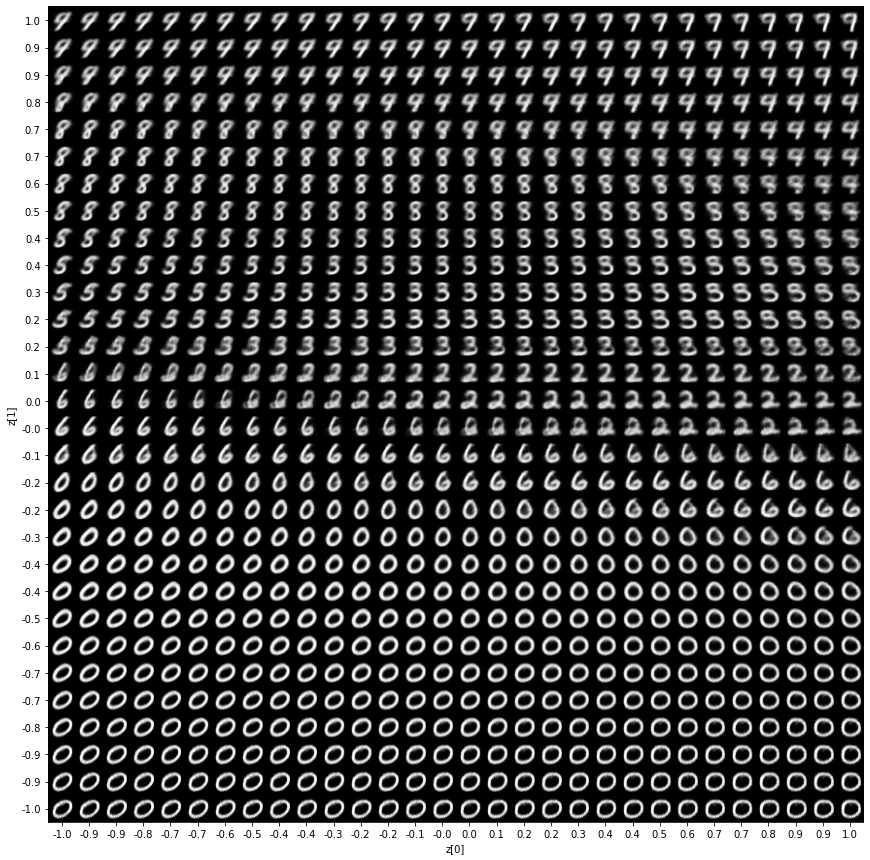

In [39]:
plot_latent_space(vae)

### Plot Label Clusters

The plot below shows the distribution of digit labels (represented by colors) in the latent space of the two components of the **z_mean** vector generated by the encoder. <br>

The VAE passes the original MNIST digit images through the encoder and we plot the label as a function of the two components of the **z_mean** vector. <br>

We can see, for example, that the model thinks that 0's and 1's are spatially dissimilar from 8's and 9's. 

1875/1875 [==============================] - 3s 2ms/step


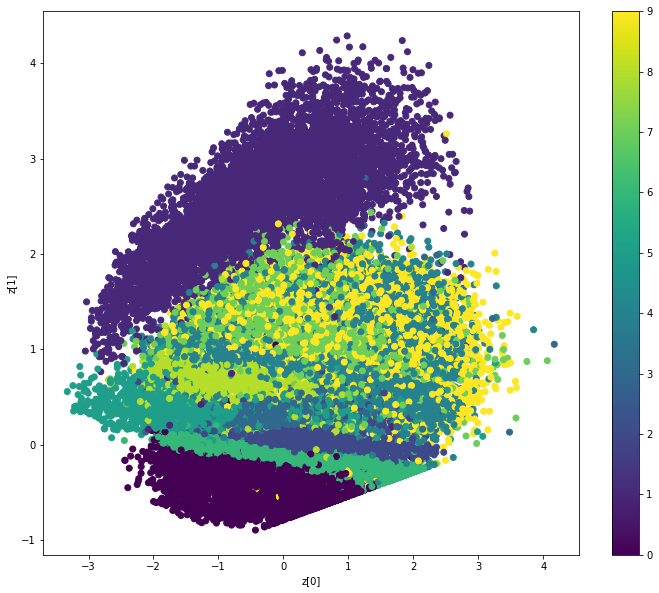

In [51]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean , _, _= vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

1875/1875 [==============================] - 3s 2ms/step


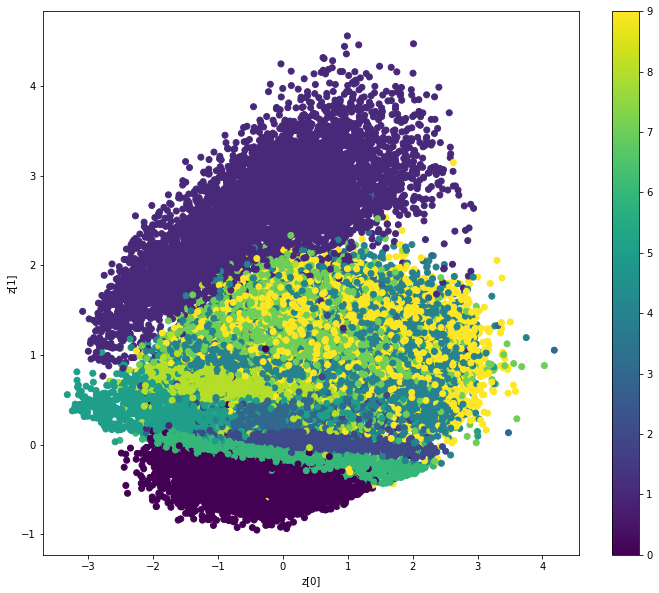

In [50]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    _, _, z_mean = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

-----
### Time for Questions

In your own words, answer as many of the following questions as you can. 

**Question 1:**

In a couple of simple sentences, **describe the differences between a Standard Auto-Encoder and a Variational Auto-Encoder.**

Think how you would describe the differences to a non-data scientist over a cup of coffee. 


A standard auto-encoder strictly learns the most important features of an input. An autoencoder will attempt to recreate the exact images with which it was trained. Variational autoencoders add "variation" and generate, as opposed to an attempt to recreate, images that are very similar.

**Question 2:**

Now in technical detail, **describe the differences between a Standard Auto-Encoder and a Variational Auto-Encoder.** 

Think about how you would describe the differences in a technical interview. Imagine the interviewer hasn't asked you for in-depth technical details like the equation of the KL Divergence loss function, so you don't want to get lost in the weeds of technical detail. But you do want your explanation to show that you could talk about the technical details if he asked you a follow up question. 


Standard auto-encoders attempt to learn the definitive latent representations of their input, while variational auto-encoders go a step further and learn the probabilistic distributions of these same latent representations.


**Question 3:**

How would you describe the technical details of the **KL Divergence** loss function to a fellow data science student outside the context of a VAE?

KL Divergence is a loss function that compares an empiric probability distribution to a reference, theoretical distribution. 



**Question 4:**

How would you describe the technical details of the entire loss function **Binary CrossEntropy** and **KL Divergence** loss functions in the context of a VAE in a technical interview?

Binary cross entropy as a loss function describes how well our autoencoder did at reconstructing an input. The KL divergence describes the variation of the latent vector representations from normality. Taken together, they describe the performance of a trained variational autoencoder model.